## import libary

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.image as mping
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, Activation, Cropping2D, Dropout, Flatten
from keras.models import Sequential,Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# def read_csv(csv_pathname):
#     csv_colums = ["center","left","right","steering","throttle","brake","speed"]
#     with open(csv_pathname) as cvsfile:
#         csv_data = pd.read_csv(cvsfile,names=csv_colums)
#     return csv_data  

# csv_data = read_csv("./data/driving_log.csv")
# csv_data.head()

### import images data

In [3]:
def getImagesAngles(csv_path):
    """
    Get center, left, right images and angles from csv_data
    
    Arguments:
        csv_data: CVS data
    Returns:
        centerimages,leftimages,rightimages,angles
    """
    csv_colums = ["center","left","right","steering","throttle","brake","speed"]
    
    # Read CSV file
    with open(csv_path) as cvsfile:
        csv_data = pd.read_csv(cvsfile,names=csv_colums)
    
    # Read images and angles
    headpath = os.path.split(csv_path)[0]
    centerimages = []
    leftimages = []
    rightimages = []
    angles = []
    for c,l,r,a in zip(csv_data["center"],csv_data["left"],csv_data["right"],csv_data["steering"]):
        c_current_path = headpath + '/IMG/' + c.split('\\')[-1] # center images current path
        l_current_path = headpath + '/IMG/' + l.split('\\')[-1] # left images current path
        r_current_path = headpath + '/IMG/' + r.split('\\')[-1] # right images current path
        
        centerimage = mping.imread(c_current_path)
        leftimage = mping.imread(l_current_path)
        rightimage = mping.imread(r_current_path)
        
        centerimages.append(centerimage)
        leftimages.append(leftimage)
        rightimages.append(rightimage)
        angles.append(a)
    
    return centerimages, leftimages, rightimages, angles

def combineImagesAngles(centerimages, leftimages, rightimages,angles, correction):
    """
    Combine "center", "left", "right" images using the correction factor "correction"
    
    Returns:
        images, measurements
    """
    images = []
    images.extend(centerimages)
    images.extend(leftimages)
    images.extend(rightimages)
    
    measurements = []
    measurements.extend(angles)
    measurements.extend(x + correction for x in angles) # left image angle move to center, angle is list can not using (angles - correction)
    measurements.extend(x - correction for x in angles) # right image angle move to center
    
    return np.array(images), np.array(measurements)

# def generator(images, angles, batch_size = 128):
#     """
#     Generate the required images and measurments for taining
#     """
#     num_samples = len(images)
#     while 1: 
#         for offset in range(0,num_samples,batch_size):
#             batch_images = images[offset:offset + batch_size]
#             batch_angles = angles[offset:offset + batch_size]
            
#         inputs = np.array(batch_images)
#         outputs = np.array(batch_angles)
#         yield inputs,outputs

## Road 1 Anticlockwise data

In [4]:
centerimages1, leftimages1,rightimages1,angles1 = getImagesAngles("./data1_anticlockwise/driving_log.csv") 
print(np.shape(centerimages1))
print(np.shape(leftimages1))
print(np.shape(rightimages1))
print(np.shape(angles1))

(2453, 160, 320, 3)
(2453, 160, 320, 3)
(2453, 160, 320, 3)
(2453,)


In [5]:
X_train1, y_train1 = combineImagesAngles(centerimages1, leftimages1, rightimages1, angles1,0.2)
print(X_train1.shape)
print(y_train1.shape)

(7359, 160, 320, 3)
(7359,)


## Road 1 Clockwise data

In [7]:
centerimages2, leftimages2, rightimages2, angles2 = getImagesAngles("./data1_clockwise/driving_log.csv") 
print(np.shape(centerimages2))
print(np.shape(leftimages2))
print(np.shape(rightimages2))
print(np.shape(angles2))

(1861, 160, 320, 3)
(1861, 160, 320, 3)
(1861, 160, 320, 3)
(1861,)


In [8]:
X_train2, y_train2 = combineImagesAngles(centerimages2, leftimages2, rightimages2, angles2,0.2)
print(X_train2.shape)
print(y_train2.shape)

(5583, 160, 320, 3)
(5583,)


## Road 2 data

In [9]:
# centerimages3, leftimages3, rightimages3, angles3 = getImagesAngles("./data2/driving_log.csv") 
# print(np.shape(centerimages3))
# print(np.shape(leftimages3))
# print(np.shape(rightimages3))
# print(np.shape(angles3))

(3489, 160, 320, 3)
(3489, 160, 320, 3)
(3489, 160, 320, 3)
(3489,)


In [10]:
# X_train3, y_train3 = combineImagesAngles(centerimages3, leftimages3,rightimages3,angles3 ,0.2)
# print(X_train3.shape)
# print(y_train3.shape)

(10467, 160, 320, 3)
(10467,)


## Merge data

In [18]:
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
print(X_train.shape)
print(y_train.shape)

(12942, 160, 320, 3)
(12942,)


## Model Architecture

In [19]:
x = Input(shape=(160,320,3))
y = Lambda(lambda x: x/250.0 - 0.5)(x)
y = Cropping2D(cropping=((70,25),(0,0)))(y)
y = Conv2D(24,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.5)(y)
y = Flatten()(y)
y = Dense(100,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(50,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(10,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.2)(y)
y = Dense(1)(y)
model = Model(inputs=x, outputs=y)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 35, 64)         27712     
__________

In [20]:
def trainModel(model=model, X_train=X_train, y_train=y_train, batch_size=128, epochs=50, lr=0.0005, patience=10, savefile='./model.h5'):
    adam_optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=adam_optimizer,loss=keras.losses.mean_squared_error)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience)
    
    train_history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, verbose=1, callbacks=[earlystop], validation_split=0.2, shuffle=True)
    
    model.save(savefile)
    
    # plot the training and validation loss for each epoch
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='best')
    plt.show()

Train on 10353 samples, validate on 2589 samples
Epoch 1/50
10353/10353 [==============================] - 14s 1ms/step - loss: 0.1834 - val_loss: 0.1306
Epoch 2/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0958 - val_loss: 0.0873
Epoch 3/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0686 - val_loss: 0.0698
Epoch 4/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0556 - val_loss: 0.0609
Epoch 5/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0475 - val_loss: 0.0564
Epoch 6/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0427 - val_loss: 0.0548
Epoch 7/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0391 - val_loss: 0.0458
Epoch 8/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0366 - val_loss: 0.0458
Epoch 9/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0350 - val_loss: 0.0421
Epoch 

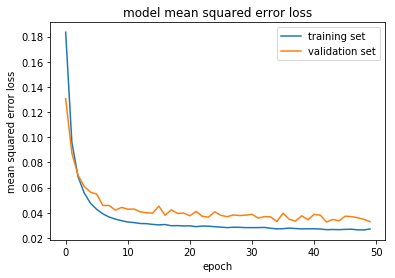

In [21]:
trainModel(model,X_train,y_train)

In [22]:
from keras.models import load_model

def finetuneModel( X_train, y_train, lr=0.0001, loadfile='./model.h5'):
    model = load_model(loadfile)
    trainModel(model,X_train,y_train,lr=lr,savefile=loadfile)

Train on 10353 samples, validate on 2589 samples
Epoch 1/50
10353/10353 [==============================] - 13s 1ms/step - loss: 0.0252 - val_loss: 0.0336
Epoch 2/50
10353/10353 [==============================] - 12s 1ms/step - loss: 0.0246 - val_loss: 0.0337
Epoch 3/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0244 - val_loss: 0.0370
Epoch 4/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0243 - val_loss: 0.0346
Epoch 5/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0244 - val_loss: 0.0325
Epoch 6/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0239 - val_loss: 0.0330
Epoch 7/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0238 - val_loss: 0.0329
Epoch 8/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0240 - val_loss: 0.0339
Epoch 9/50
10353/10353 [==============================] - 11s 1ms/step - loss: 0.0237 - val_loss: 0.0320
Epoch 

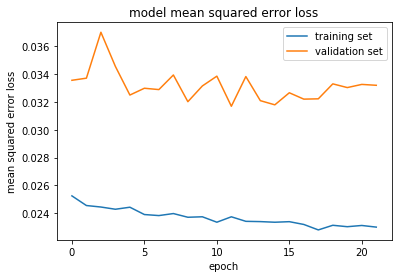

In [23]:
finetuneModel(X_train, y_train, lr=0.0001)